In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from collections import Counter

### 1. Load and Inspect the Data

In [2]:
data = pd.read_csv('covtype.csv')

In [3]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [5]:
print(f"Initial shape: {data.shape}")
print(f"Missing values: {data.isnull().sum().sum()}")
print(f"Duplicate rows: {data.duplicated().sum()}")

Initial shape: (581012, 55)
Missing values: 0
Duplicate rows: 0


In [6]:
data = data.drop_duplicates()
print(f"Shape after deduplication: {data.shape}")

Shape after deduplication: (581012, 55)


### 2. Validate Data Consistency

In [7]:
def validate_covertype(df):
  """Check for basic data integrity rules."""
  assert (df['Elevation'] >= 0).all(), "Negative elevation found"
  assert (df['Slope'].between(0, 90)).all(), "Invalid slope values"
  assert (df['Horizontal_Distance_To_Hydrology'] >= 0).all(), "Negative distance"
  print("Data validation passed")

In [8]:
validate_covertype(data)

Data validation passed


### 3. Split Features and Labels

In [9]:
X = data.drop(columns='Cover_Type')
y = data['Cover_Type']

## 4. Feature Selection

### - Remove Low Variance Features

In [10]:
def remove_low_variance(df, threshold=0.01):
    print(f"\n--- Low Variance Feature Removal (threshold={threshold}) ---")
    print(f"Original shape: {df.shape}")
    
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df)
    
    mask = selector.get_support()
    removed = df.columns[~mask].tolist()
    
    if removed:
        print(f"Removed {len(removed)} low-variance feature(s): {removed}")
    else:
        print("No low-variance features found.")
        
    return df.loc[:, mask], removed

In [11]:
X_clean, low_var_removed = remove_low_variance(X)


--- Low Variance Feature Removal (threshold=0.01) ---
Original shape: (581012, 54)
Removed 21 low-variance feature(s): ['Soil_Type1', 'Soil_Type3', 'Soil_Type5', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type21', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37']


### - Remove Highly Correlated Features

In [12]:
def plot_correlation_heatmap(df, title):
    plt.figure(figsize=(18, 15))
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap='coolwarm', center=0,
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title(title, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


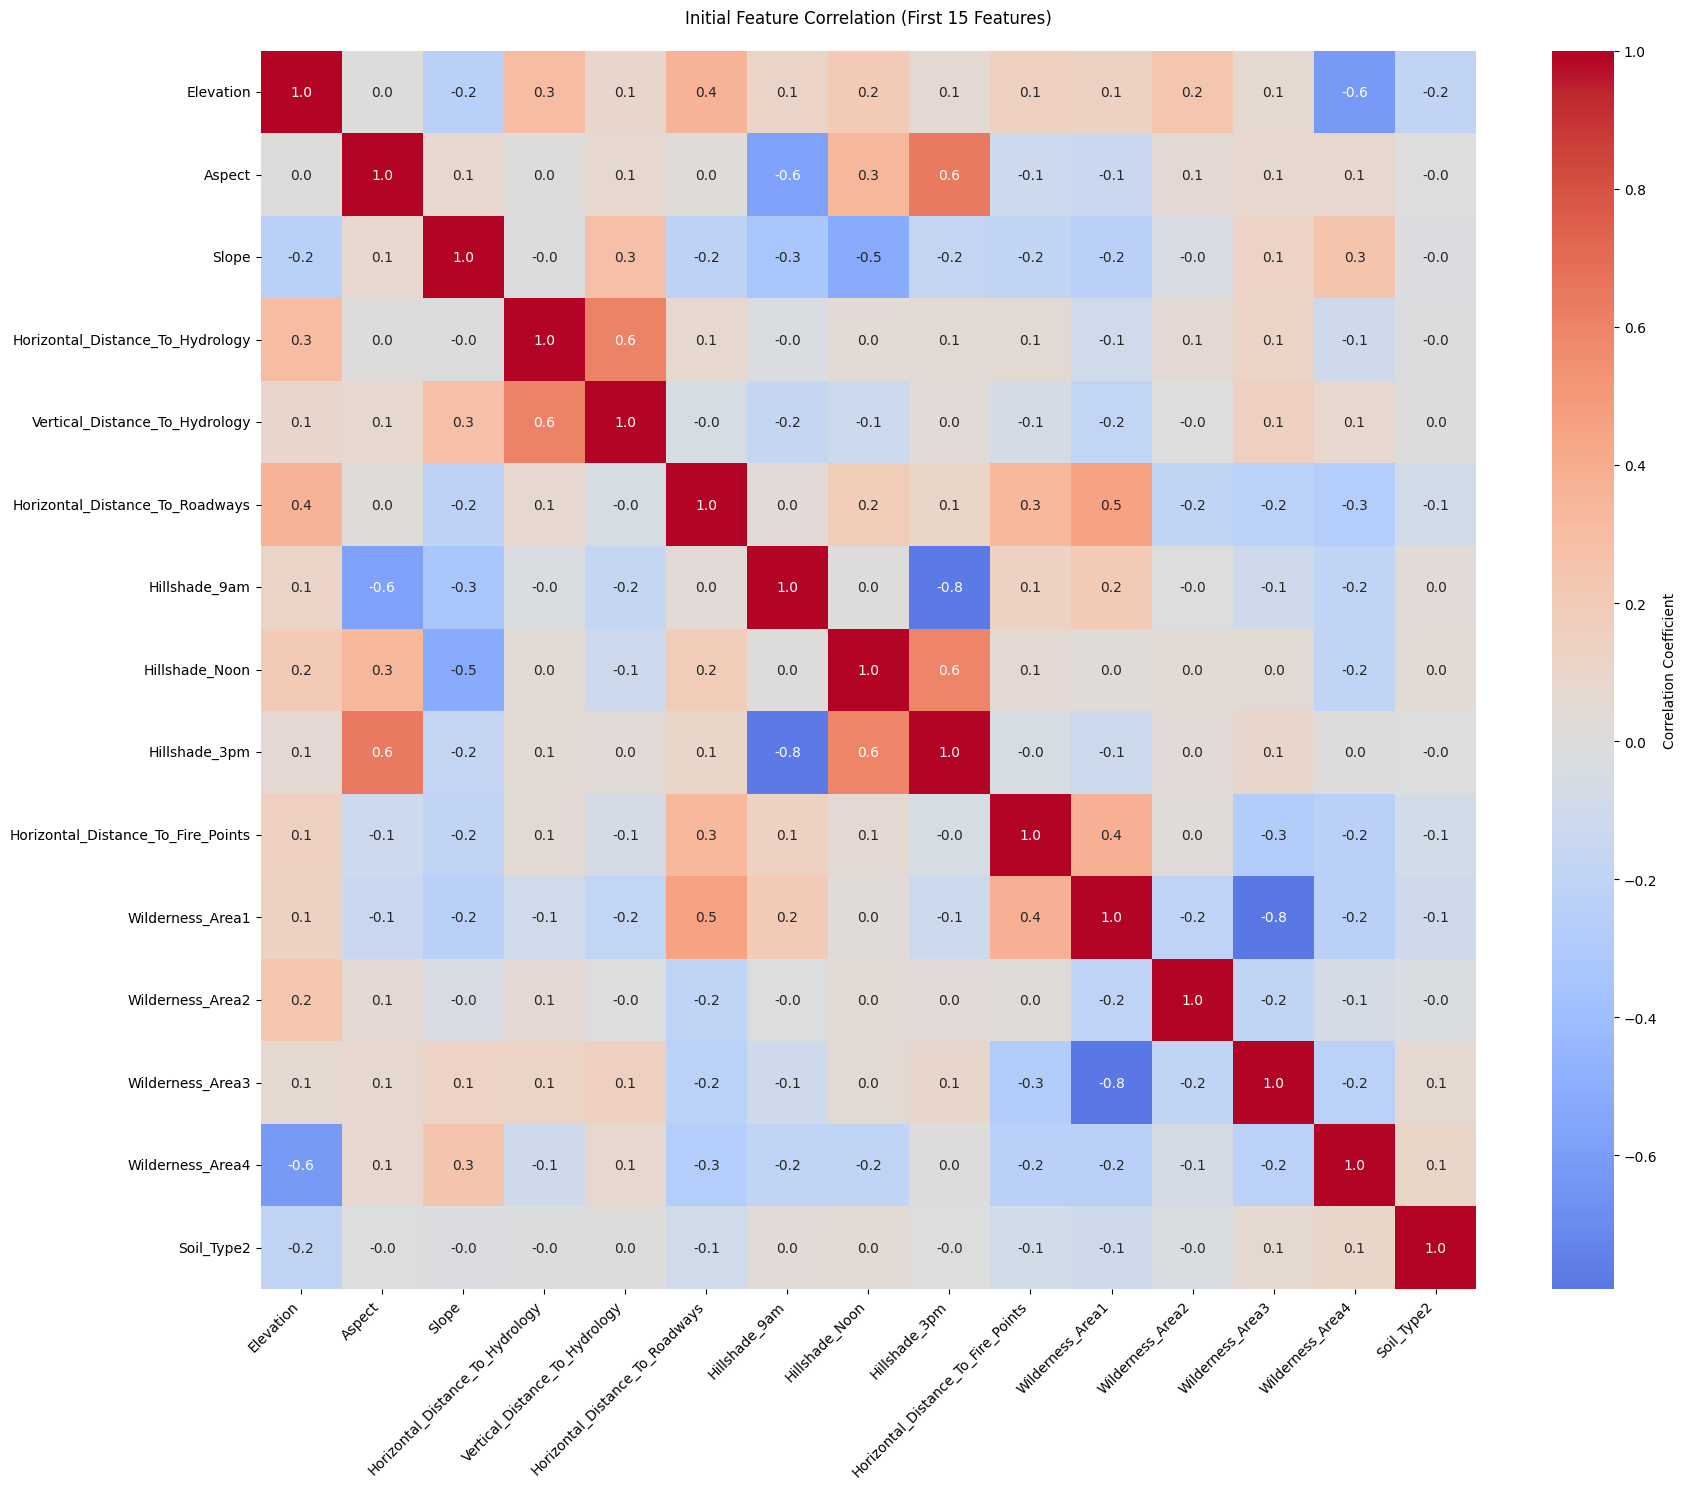

In [13]:
# Plot before correlation removal
plot_correlation_heatmap(X_clean.iloc[:, :15], "Initial Feature Correlation (First 15 Features)")

In [14]:
def remove_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    if to_drop:
        print(f"Removed {len(to_drop)} correlated features: {to_drop}")
    else:
        print("No correlated features found")
    return df.drop(columns=to_drop), to_drop

In [15]:
X_final, corr_removed = remove_correlated_features(X_clean)

if corr_removed:
  plot_correlation_heatmap(X_final.iloc[:, :min(15, len(X_final.columns))], "Feature Correlation After Removal")


No correlated features found


## 5. Create a Balanced Sample

In [16]:
count_df = pd.DataFrame({'Cover_Type': y})
count_df = count_df['Cover_Type'].value_counts().reset_index()
count_df.columns = ['Cover_Type', 'Count']

fig1 = px.bar(count_df, 
              x='Cover_Type', 
              y='Count', 
              title='Cover Type Distribution (Before Taking A Sample)', 
              color='Cover_Type')
fig1.show()

In [17]:
def get_balanced_sample(X, y, min_samples=13001):
    X_array = X.values
    y_array = y.values
    class_counts = Counter(y_array)
    samples_per_class = max(min_samples // len(class_counts), 1)
    
    sampled_indices = []
    for class_val in class_counts:
        class_indices = np.where(y_array == class_val)[0]
        sampled = np.random.choice(class_indices, 
                                   size=min(samples_per_class, len(class_indices)), 
                                   replace=False)
        sampled_indices.extend(sampled)
    
    return X_array[sampled_indices], y_array[sampled_indices]

In [18]:
X_balanced, y_balanced = get_balanced_sample(X_final, y)
print(f"Balanced sample shape: {X_balanced.shape}")
print("Class distribution:", Counter(y_balanced))

# balanced_df = X_balanced.copy()
# balanced_df['Cover_Type'] = y_balanced

# balanced_df.to_csv("balanced_covertype_sample.csv", index=False)

Balanced sample shape: (12999, 33)
Class distribution: Counter({5: 1857, 2: 1857, 1: 1857, 7: 1857, 3: 1857, 6: 1857, 4: 1857})


### - Scale the Features

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

In [20]:
count_df = pd.DataFrame({'Cover_Type': y_balanced})
count_df = count_df['Cover_Type'].value_counts().reset_index()
count_df.columns = ['Cover_Type', 'Count']

fig1 = px.bar(count_df, 
              x='Cover_Type', 
              y='Count', 
              title='Cover Type Distribution (Balanced Sample)', 
              color='Cover_Type')
fig1.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42)
svm_33 = SVC(kernel='linear', random_state=42)
svm_33.fit(X_train, y_train)
y_pred_33 = svm_33.predict(X_test)
acc_33 = accuracy_score(y_test, y_pred_33)
print(acc_33*100)

70.3076923076923


## 6. Dimensionality Reduction with PCA

In [22]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import numpy as np

# Run PCA on the scaled data without limiting components
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Explained variance
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(cumulative_variance)+1)),
    y=cumulative_variance,
    mode='lines+markers',
    name='Cumulative Explained Variance'
))

fig.add_hline(
    y=0.90,
    line_dash='dash',
    line_color='red',
    annotation_text='95% Variance Threshold',
    annotation_position='bottom right'
)

fig.update_layout(
    title='PCA: Explained Variance vs. Number of Components',
    xaxis_title='Number of Principal Components',
    yaxis_title='Cumulative Explained Variance',
    xaxis=dict(dtick=1),
    template='plotly_white',
    height=500
)

fig.show()

# Optional: Print the number of components needed to reach 95%
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components_90}")

Number of components to retain 90% variance: 22


In [23]:
pca = PCA(n_components=20) 
X_pca = pca.fit_transform(X_scaled)

# Visualize explained variance
explained_var = np.cumsum(pca.explained_variance_ratio_)
explained_df = pd.DataFrame({
    'Component': np.arange(1, len(explained_var) + 1),
    'Cumulative Explained Variance': explained_var
})

fig = px.line(explained_df, 
              x='Component', 
              y='Cumulative Explained Variance',
              title='Cumulative Explained Variance by PCA Components',
              markers=True)
fig.update_layout(xaxis_title='Number of Components', yaxis_title='Cumulative Variance Ratio')
fig.show()


In [24]:
# Visualize PCA result (2D projection)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Combine with labels for Plotly
pca_2d_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
pca_2d_df['Cover_Type'] = y_balanced

fig2 = px.scatter(pca_2d_df, x='PC1', y='PC2', color='Cover_Type', 
                  title='2D PCA Projection of Balanced Sample',
                  color_continuous_scale='Viridis')
fig2.show()

In [25]:
# Step 1: Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_balanced) 

# Step 2: Create DataFrame with labels
pca_3d_df = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['Cover_Type'] = y_balanced 

# Step 3: 3D Scatter Plot
fig3d = px.scatter_3d(
    pca_3d_df, x='PC1', y='PC2', z='PC3',
    color='Cover_Type',
    title='3D PCA Projection of Balanced Sample',
    color_continuous_scale='Viridis'
)
fig3d.show()

## Support vector Machine

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay ,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (10399, 33)
Testing set size: (2600, 33)


In [28]:
''''
# Subsample the dataset for hyperparameter tuning
X_subsample, _, y_subsample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
print("x subsample size:", X_subsample.shape)
print("y subsample size:", y_subsample.shape)
'''

'\'\n# Subsample the dataset for hyperparameter tuning\nX_subsample, _, y_subsample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)\nprint("x subsample size:", X_subsample.shape)\nprint("y subsample size:", y_subsample.shape)\n'

In [29]:
from sklearn.model_selection import StratifiedKFold

SVM_MODEL = SVC(decision_function_shape='ovo', probability=True, class_weight='balanced')

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['rbf']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(SVM_MODEL, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
best_svm.fit(X_train,y_train)
y_pred = best_svm.predict(X_test)

In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate metrics
metrics = {
    "F1 Score (macro)": f1_score(y_test, y_pred, average='macro'),
    "Precision (macro)": precision_score(y_test, y_pred, average='macro'),
    "Recall (macro)": recall_score(y_test, y_pred, average='macro')
}

# Print metrics
print("\nOverall Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Detailed class-wise report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.82

Overall Metrics:
F1 Score (macro): 0.8198
Precision (macro): 0.8186
Recall (macro): 0.8222

Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.71      0.70       360
           2       0.69      0.64      0.67       391
           3       0.82      0.74      0.78       388
           4       0.91      0.95      0.93       365
           5       0.90      0.93      0.92       378
           6       0.79      0.83      0.81       362
           7       0.92      0.96      0.94       356

    accuracy                           0.82      2600
   macro avg       0.82      0.82      0.82      2600
weighted avg       0.82      0.82      0.82      2600



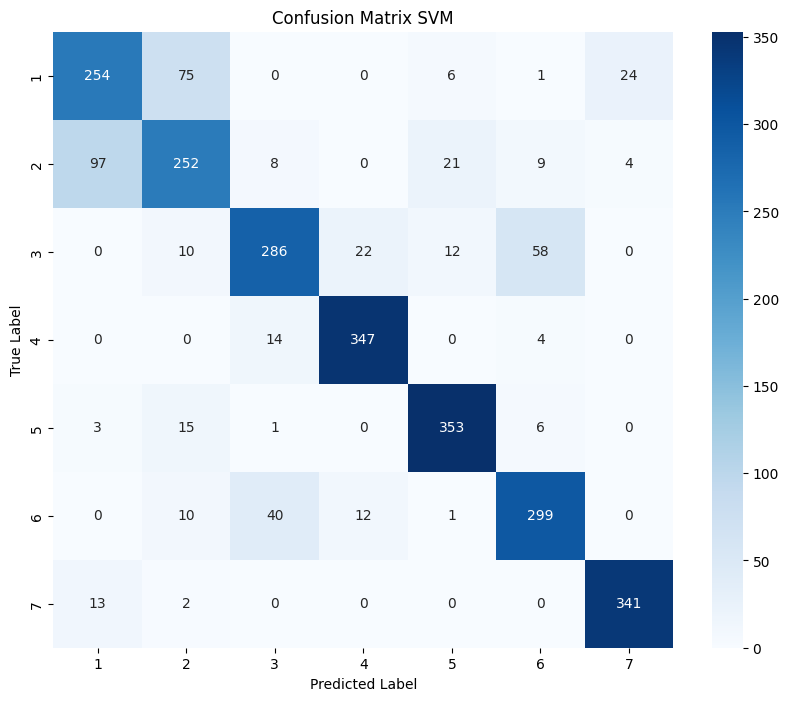

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.title('Confusion Matrix SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [33]:
import plotly.express as px
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Melt dataframe for Plotly
metrics_df = report_df.reset_index().melt(id_vars='index', 
                                        value_vars=['precision', 'recall', 'f1-score'],
                                        var_name='Metric')

fig = px.bar(metrics_df, 
             x='index', 
             y='value', 
             color='Metric',
             barmode='group',
             color_discrete_map={'precision':'#ADD8E6', 
                                'recall':'#00008B', 
                                'f1-score':'#87CEEB'},
             title='<b>Classification Metrics by Class</b>',
             labels={'index':'Class', 'value':'Score'},
             text_auto='.2f')

fig.update_layout(
    hovermode='x unified',
    yaxis_range=[0,1.1],
    plot_bgcolor='rgba(245,245,245,0.8)',
    height=500
)
fig.show()

In [34]:
with open("SVM.pkl", "wb") as f:
    pickle.dump(best_svm, f)

In [35]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the model
RF_MODEL = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
rf_grid_search = GridSearchCV(RF_MODEL, rf_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best model and parameters
best_rf = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_

print("Best Parameters for Random Forest:", best_rf_params)

Best Parameters for Random Forest: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [38]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = best_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8465384615384616
              precision    recall  f1-score   support

           1       0.74      0.78      0.76       360
           2       0.81      0.65      0.72       391
           3       0.87      0.75      0.80       388
           4       0.90      0.97      0.93       365
           5       0.90      0.94      0.92       378
           6       0.79      0.89      0.83       362
           7       0.92      0.97      0.94       356

    accuracy                           0.85      2600
   macro avg       0.85      0.85      0.84      2600
weighted avg       0.85      0.85      0.84      2600

